First we import the required libraries, numpy for calculational stuff, pandas for dataset, matplotlib for plotting.
Then import the dataset, and take an overview of it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#here path is the same folder as this notebook
path="Task2_dataset.csv"
df=pd.read_csv(path)
df

,song_id,keyword_1,keyword_2,keyword_3,genre
0,74,guitar,happy,distorted,rock
1,103,brass,energetic,melodic,classical
2,201,banjo,happy,acoustic,country
3,194,synth,energetic,heavy,hip-hop
4,184,synth,energetic,slow,hip-hop
...,...,...,...,...,...
142,195,synth,angry,melodic,hip-hop
143,7,guitar,energetic,fast,pop
144,14,guitar,happy,rhythmic,pop
145,36,synth,mellow,danceable,pop


Overview of the arrays made and used ahead:
sentences= an array whose each element itself is an array containing the value keyword_1, keyword_2, keyword_3 for each song.
true_genres= array containing the labels for actual genres for each song - we require this later to calculate confusion matrix

word_set= it is like a vocab, it contains all the unique words(from keyword 1,2,3) in the dataset.
index_dict= this is a dictionary which maps each word in the word_set to a number (index), this would be used for BoW matrix calculations

In [3]:
k1 = df['keyword_1'].to_numpy()
k2=df['keyword_2'].to_numpy()
k3= df['keyword_3'].to_numpy()
true_genres=df['genre'].to_numpy()

In [4]:
print(f"Vocab keyword 1: {set(k1)}, Size of vocab: {len(set(k1))}")
print(f"Vocab keyword 2: {set(k2)},Size of vocab: {len(set(k2))}")
print(f"Vocab keyword 3: {set(k3)}, Size of vocab: {len(set(k3))}")

Vocab keyword 1: {'banjo', 'brass', 'synth', 'violin', 'guitar', 'piano'}, Size of vocab: 6
Vocab keyword 2: {'angry', 'emotional', 'sad', 'energetic', 'nostalgic', 'upbeat', 'mellow', 'happy', 'calm'},Size of vocab: 9
Vocab keyword 3: {'heavy', 'danceable', 'distorted', 'acoustic', 'slow', 'upbeat', 'fast', 'rhythmic', 'twangy', 'melodic'}, Size of vocab: 10


In [5]:
def create_index_dict(keywords):
    word_set = set(keywords)
    index_dict = {word: i for i, word in enumerate(word_set)}
    return index_dict, word_set

In [6]:
index_dict = []
word_set = []

for keywords in [k1, k2, k3]:
    idx_dict, w_set = create_index_dict(keywords)
    index_dict.append(idx_dict)
    word_set.append(w_set)

BoW Matrix: 
For each keyword column we have built a seperate word set and index dict, we use that now to build the BoW matrix

In [7]:
def create_bow_matrix(keywords, word_set, index_dict):
    bow_matrix = np.zeros((len(keywords), len(word_set)), dtype=int)
    for i, word in enumerate(keywords):
        bow_matrix[i, index_dict[word]] += 1
    return bow_matrix

In [8]:
bow_matrix_k1=create_bow_matrix(k1,word_set[0], index_dict[0])
bow_matrix_k2=create_bow_matrix(k2,word_set[1], index_dict[1])
bow_matrix_k3=create_bow_matrix(k3,word_set[2], index_dict[2])
print(bow_matrix_k1[:5])

[[0 0 0 0 1 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]]


PCA: 

In [9]:
def pca(X, n_components=2):
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    covariance_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigentf_idf_arr = np.linalg.eig(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigentf_idf_arr = eigentf_idf_arr[:, sorted_indices]
    principal_components = eigentf_idf_arr[:, :n_components]
    X_reduced = np.dot(X_centered, principal_components)
    
    return X_reduced

In [10]:
red_bow_k1=pca(bow_matrix_k1)
red_bow_k2=pca(bow_matrix_k2)
red_bow_k3=pca(bow_matrix_k3)

Combine embeddings: 
We use 3 methods: Simple average, Hadamard product, Cosine similarity.
For cosine similarity we calculate it pairwise so in total we have 3 matrices, and finally we combine them. Our first column of the combined matrix is the average of the cos similarity of reduced k1 & reduced k2, second column is average of cos similarity of reduced k2 and reduced k3

In [11]:
def cosine_similarity(A, B):
    dot_product = np.sum(A * B, axis=1)  
    norm_A = np.linalg.norm(A, axis=1)  
    norm_B = np.linalg.norm(B, axis=1)
    return dot_product / (norm_A * norm_B + 1e-10)  # We add a very small number so as to avoid division by zero

def combine_embeddings(A, B, C, method="average"):
    if method == "average":
        combined_embedding = (A + B + C) / 3
    elif method == "mult":
        combined_embedding = A * B * C
    elif method == "cos":
        cos1 = cosine_similarity(A, B)  
        cos2 = cosine_similarity(B, C)  
        cos3 = cosine_similarity(A, C) 
        combined_embedding = np.column_stack(((cos1 + cos3) / 2, (cos2 + cos3) / 2))  
    return combined_embedding

final_embeddings = combine_embeddings(red_bow_k1, red_bow_k2, red_bow_k3, method="cos")

print("\nFinal Combined 2D Embeddings:\n", final_embeddings[:5])



Final Combined 2D Embeddings:
 [[ 0.26032655 -0.43790183]
 [ 0.29248477 -0.37449565]
 [ 0.24836355  0.29996394]
 [-0.09808634  0.4178987 ]
 [-0.15941664  0.34521162]]


We apply z-score normalization to ensure data is evenly spread out

In [12]:
def z_score_normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0, ddof=0) 
    return ((data - mean) / std) 

normalized_data = z_score_normalize(final_embeddings)
print(normalized_data[:5])

[[ 0.56664548 -1.04648183]
 [ 0.62919139 -0.90967783]
 [ 0.54337813  0.54552358]
 [-0.13044723  0.79997742]
 [-0.24973118  0.64314912]]


We use kmeans++ algorithm

In [61]:
import numpy as np

def kmeans_plus_plus(data, k, max_iters=50000, tol=1e-6):
    np.random.seed(3000)  # For reproducibility
    n_samples, n_features = data.shape

    # Step 1: Initialize first centroid randomly
    first_index = np.random.randint(0, n_samples)
    centroids = [data[first_index].tolist()]

    # Step 2: Select remaining k-1 centroids
    for _ in range(1, k):
        distances = []
        for i in range(n_samples):
            min_dist = float('inf')
            for centroid in centroids:
                dist = np.linalg.norm(data[i] - np.array(centroid))
                if dist < min_dist:
                    min_dist = dist
            distances.append(min_dist ** 2)

        total_dist = sum(distances)
        probabilities = [d / total_dist for d in distances]

        chosen_index = np.random.choice(n_samples, p=probabilities)
        centroids.append(data[chosen_index].tolist())

    centroids = np.array(centroids)

    # Step 3: Run standard k-means
    for _ in range(max_iters):
        labels = np.zeros(n_samples, dtype=int)
        new_centroids = np.zeros((k, n_features))
        counts = np.zeros(k)

        # Assign clusters
        for i in range(n_samples):
            min_dist = float('inf')
            best_cluster = -1
            for j in range(k):
                dist = np.linalg.norm(data[i] - centroids[j])
                if dist < min_dist:
                    min_dist = dist
                    best_cluster = j
            labels[i] = best_cluster

        # Compute new centroids
        for i in range(n_samples):
            cluster = labels[i]
            new_centroids[cluster] += data[i]
            counts[cluster] += 1

        for j in range(k):
            if counts[j] > 0:
                new_centroids[j] /= counts[j]

        # Check convergence
        converged = True
        for j in range(k):
            if np.linalg.norm(new_centroids[j] - centroids[j]) >= tol:
                converged = False
                break
        
        if converged:
            break

        centroids = new_centroids

    return labels, centroids

# Example usage
k = 5
labels, centroids = kmeans_plus_plus(normalized_data, k)

Plotting the scatter plot of cluster centroids and final embeddings, where each cluster is given a unique colour

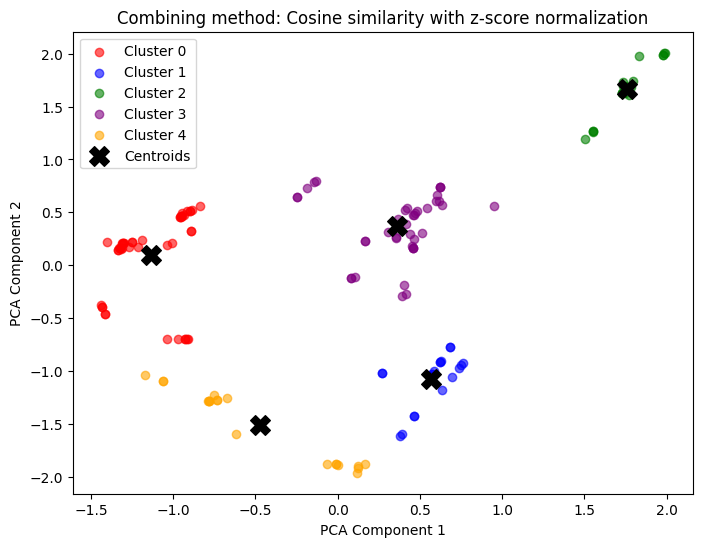

In [62]:
# Scatter plot
plt.figure(figsize=(8, 6))

# Assign unique colors to clusters
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Plot each cluster with different colors
for cluster_id in range(k):
    cluster_points = normalized_data[labels == cluster_id]  # Select points in this cluster
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                color=colors[cluster_id], label=f'Cluster {cluster_id}', alpha=0.6)

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], 
            color='black', marker='X', s=200, label='Centroids')

# Titles & Legends
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Combining method: Cosine similarity with z-score normalization")
plt.legend()
plt.show()


Calculating Silhouette Score

In [63]:
from sklearn.metrics import silhouette_score

silhouette_score_kmeans = silhouette_score(normalized_data, labels)
print(f"Silhouette Score: {silhouette_score_kmeans:.4f}")

Silhouette Score: 0.6250


Ground Truth/Confusion Matrix expressed in percentage

In [64]:
unique_genres = np.unique(true_genres)  # Example: ['classical', 'jazz', 'pop', 'rock', 'electronic']

# Create a DataFrame to store percentage distributions
cluster_distribution = pd.DataFrame(0, index=range(k), columns=unique_genres)

# Count occurrences of each genre in each cluster
for cluster_id in range(k):
    cluster_songs = true_genres[labels == cluster_id]  # Get true genres in the current cluster
    for genre in unique_genres:
        cluster_distribution.loc[cluster_id, genre] = np.sum(cluster_songs == genre)

# Convert to percentage
cluster_distribution_percentage = cluster_distribution.div(cluster_distribution.sum(axis=1), axis=0) * 100

# Display the percentage distribution per cluster
print(cluster_distribution_percentage)


   classical    country    hip-hop        pop       rock
0   8.695652  26.086957  10.869565  21.739130  32.608696
1  14.285714  19.047619  23.809524  19.047619  23.809524
2  35.000000  20.000000  15.000000  25.000000   5.000000
3  20.000000  10.000000  35.000000  25.000000  10.000000
4  25.000000  25.000000  15.000000  10.000000  25.000000


Assigning each cluster to a unique genre depending on which genre has the maximum songs in that cluster, this is done by building a frequency matrix(dataframe in this case).
`true_genres` contains the actual genre labels of the songs in the dataset
`labels` is the K-Means assigned cluster for each song

In [65]:
k = 5  # Number of clusters
unique_genres = np.unique(true_genres)  # Set of actual genres

# Frquency distribution dataframe
cluster_distribution = pd.DataFrame(0, index=range(k), columns=unique_genres)

for i in range(len(true_genres)):
    cluster_distribution.loc[labels[i], true_genres[i]] += 1 

print(cluster_distribution)

# Assign the most common genre in each cluster
cluster_to_genre = cluster_distribution.idxmax(axis=1).to_dict()
print("Cluster to Genre Mapping:", cluster_to_genre)

   classical  country  hip-hop  pop  rock
0          4       12        5   10    15
1          3        4        5    4     5
2          7        4        3    5     1
3          8        4       14   10     4
4          5        5        3    2     5
Cluster to Genre Mapping: {0: 'rock', 1: 'hip-hop', 2: 'classical', 3: 'hip-hop', 4: 'classical'}


Since hip-hop occurs twice and country not even once, looking at the frequency matrix we replace index 2 with country (for detailed explanation see whitepaper)

In [67]:
cluster_to_genre[1]='pop'
cluster_to_genre[4]='country'
print(cluster_to_genre)

{0: 'rock', 1: 'pop', 2: 'classical', 3: 'hip-hop', 4: 'country'}


Building the prediction model based on distance from the centroids we have already got from kmeans

In [68]:
new_songs=[['piano', 'calm', 'slow'], ['guitar', 'emotional', 'distorted'], ['synth', 'mellow', 'distorted']]

In [69]:
def closest_cluster(data_point, centroids):
    return np.argmin(np.linalg.norm(centroids - data_point, axis=1))  # Compute & return closest cluster index

In [71]:
#vectorizing the keywords of songs which have to be predicted
k1_new=[]
k2_new=[]
k3_new=[]
for song in new_songs:
    k1_new.append(song[0])
    k2_new.append(song[1])
    k3_new.append(song[2])
bow_new_k1=create_bow_matrix(k1_new,word_set[0], index_dict[0])
bow_new_k2=create_bow_matrix(k2_new,word_set[1], index_dict[1])
bow_new_k3=create_bow_matrix(k3_new,word_set[2], index_dict[2])

red_bow_new_k1=pca(bow_new_k1)
red_bow_new_k2=pca(bow_new_k2)
red_bow_new_k3=pca(bow_new_k3)

final_embeddings_new = combine_embeddings(red_bow_new_k1, red_bow_new_k2, red_bow_new_k3, method="cos")
normalized_new_embeddings=z_score_normalize(final_embeddings_new)
print(normalized_new_embeddings)

[[-1.37240912 -1.37240912]
 [ 0.98178858  0.98178858]
 [ 0.39062053  0.39062053]]


In [72]:
#predictions
for i,data in enumerate(normalized_new_embeddings):
    cluster_idx = closest_cluster(data, centroids)
    print(f"Keywords: {new_songs[i]}  Genre: {cluster_to_genre[cluster_idx]}")

Keywords: ['piano', 'calm', 'slow']  Genre: country
Keywords: ['guitar', 'emotional', 'distorted']  Genre: hip-hop
Keywords: ['synth', 'mellow', 'distorted']  Genre: hip-hop


Bonus

Giving the final embeddings of traning data as input for prediction and comparing with the true labels and keeping count of no. of correct predictions

In [73]:
correct=0
for i in range(len(normalized_data)):
    cluster_idx = closest_cluster(normalized_data[i], centroids)
    if cluster_to_genre[cluster_idx]==true_genres[i]:
        correct+=1
print(f"{(correct * 100 / len(normalized_data)):.4f}%")

30.6122%
